# Permutation and Boosting

**Import libraries**

In [66]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

### Permutation importance

The process works something like this:

- Fit a model and calculate the accuracy
- Choose a feature (by ranking the importances or some other method) and randomly permute the values for just that feature
- Calculate the accuracy again with the permuted column
- Results in a decrease in accuracy: that feature is important to the model
- Results in an accuracy that stays the same: the feature isn't important to the model and could be replaced by random numbers

**Permutation importance example with Austrailian weather dataset**

In [51]:
df = pd.read_csv('data/weatherAUS.csv')

# Drop columns with high-percentage of missing values (and the leaky feature)
cols_drop = ['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
df = df.drop(cols_drop, axis=1)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True).dt.month

In [52]:
# Dropping rows missing RainTomorrow values
df = df[df['RainTomorrow'].notna()]

**Creating the pipline**

In [53]:
# Define the numeric features
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 
                    'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 
                    'Humidity3pm', 'Pressure9am','Pressure3pm', 
                    'Temp9am', 'Temp3pm']

# Create the transformer (impute, scale)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define the categorical features
categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())])

# Define how the numeric and categorical features will be transformed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the pipeline steps, including the classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', DecisionTreeClassifier())])


**Train and fit model**

In [54]:
# Feature Matrix
X = df.drop('RainTomorrow', axis=1)
label_enc = LabelEncoder()

y = label_enc.fit_transform(df['RainTomorrow'])

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train, y_train)
print('Validation Accuracy', clf.score(X_test, y_test))

Validation Accuracy 0.7787545272337283


**Feature Importances**

- removed the leaky featrues

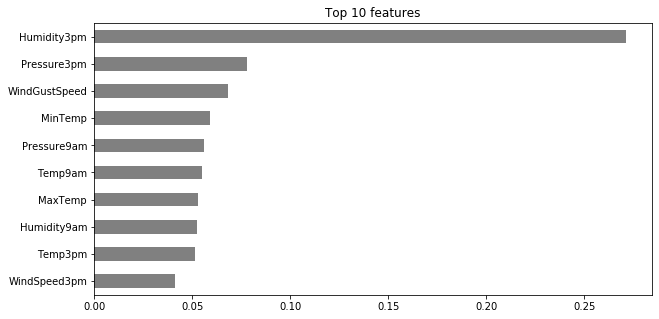

In [55]:
# Features (order in which they were preprocessed)
feature_order = numeric_features + categorical_features

importances = pd.Series(clf.steps[1][1].feature_importances_, feature_order)

# Plot feature importances
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')
plt.show();

**Performing permutation analysis on the top features**

for Humidity3pm we see a large decrease in accuracy show that feature is important to the model.

for WindSpeed3pm we do not see a huge drop in accuracy so this feature is not important to the model and can easiley be replaced with random numbers

In [56]:
# Permute the values in the more important column
feature = 'Humidity3pm'
X_test_permuted = X_test.copy()

# Fill missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median, inplace=True)

# permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  Humidity3pm
Validation Accuracy 0.7787545272337283
Validation Accuracy (permuted) 0.7006927107141602


In [57]:
# Permute the values in a less important column
feature = 'WindSpeed3pm'
X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  WindSpeed3pm
Validation Accuracy 0.7787545272337283
Validation Accuracy (permuted) 0.7670100917753789


**Bagging**

Earlier in the sprint, we used a random forest ensemble method, where the ensemble was a collection of trees. An ensemble method makes use of bootstrap sampling where random samples are drawn from the training set with replacement. A decision tree is trained on each sample and each tree gets a "vote" for the class. The class with the most votes wins. This process is called bootstrap aggregating or bagging.

**Boosting**

Another important process in machine learning is boosting. For our example, we'll start by training our data set with a weak learner which is often a decision tree with one node or split (called a stump). Then, we’ll find the data that was misclassified and start the next round by assigning those data points a larger weight. We will continue to train decision tree stumps and add larger weights to the "mistakes" from each model. The samples that are difficult to classify will receive increasingly larger weights and eventually be correctly classified. This process is called adaptive boosting and is the source of the AdaBoost() name.

**Gradient Boosting**

Gradient boosting is another boosting technique that makes use of a gradient descent method when adding trees to the model. When a tree is added, the hyperparameters are adjusted to minimize the loss function following the negative gradient. The popular XGBoost algorithm makes use of this process.

### Boosting example with iris dataset

**Random Forest**

In [67]:
# Create X, y and training/test sets
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

print('Validation Accuracy: Adaboost', model.score(X_test, y_test))

Validation Accuracy: Adaboost 0.9833333333333333


**ada_boost**

In [60]:
# Create X, y and training/test sets
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

ada_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=1.5, random_state=42)
ada_classifier.fit(X_train,y_train)

print('Validation Accuracy: Adaboost', ada_classifier.score(X_test, y_test))

Validation Accuracy: Adaboost 0.9666666666666667


**Gradient Boost**

In [64]:
xg_classifier = XGBClassifier(n_estimators=50, random_state=42, eval_metric='merror')

xg_classifier.fit(X_train,y_train)

print('Validation Accuracy: Adaboost', xg_classifier.score(X_test, y_test))

C:\Users\tyler\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validation Accuracy: Adaboost 0.9833333333333333
